Классификация дорожных знаков нa базе сверточной
неиронной сети. Построить алгоритм классификации дорожных знаков.
Использовать датасет: https://www.kaggle.com/datasets/dmitryyemelyanov/chinese-traffic-signs/discussion?sort=undefined
Алгоритм должен классифицировать знаки типов: 3,4,5,7,11,16,17,26,30,35,43,55. Необходимо использовать аугментацию данных.


In [6]:
import kagglehub
path = kagglehub.dataset_download('dmitryyemelyanov/chinese-traffic-signs')

100%|██████████| 185M/185M [00:01<00:00, 117MB/s]

Extracting files...


In [1]:
path='/root/.cache/kagglehub/datasets/dmitryyemelyanov/chinese-traffic-signs/versions/2'

In [7]:
# small_shape=(224, 224)
small_shape=(48, 48)

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [9]:
data_dir = path+'/images/'
df = pd.read_csv(path+"/annotations.csv")

In [33]:
file_paths = df['file_name'].values
images = []
for file_path in file_paths:
    image_path = os.path.join(data_dir, file_path)
    image = Image.open(image_path).resize(small_shape)
    images.append(np.array(image))

labels = df['category'].values

images = np.array(images)
labels = np.array(labels)

In [ ]:
df.columns

Index(['file_name', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'category'], dtype='object')

array([[[132, 114,  98],
        [132, 113,  98],
        [131, 113,  98],
        ...,
        [103,  89,  78],
        [102,  88,  76],
        [103,  89,  76]],

       [[134, 113,  99],
        [132, 113,  98],
        [132, 113,  97],
        ...,
        [105,  91,  77],
        [104,  90,  78],
        [104,  90,  78]],

       [[132, 114,  98],
        [132, 114,  98],
        [131, 113,  98],
        ...,
        [105,  91,  79],
        [104,  91,  79],
        [105,  91,  81]],

       ...,

       [[173,  33,  80],
        [168,  85, 105],
        [133,  87,  91],
        ...,
        [ 80,  72,  67],
        [ 71,  68,  61],
        [ 93,  85,  75]],

       [[162,  33,  74],
        [164,  75,  92],
        [135,  80,  85],
        ...,
        [ 82,  75,  67],
        [ 70,  67,  59],
        [ 91,  85,  76]],

       [[157,  25,  60],
        [162,  74,  90],
        [137,  72,  80],
        ...,
        [ 84,  76,  67],
        [ 67,  65,  58],
        [ 91,  85,  75]]], dtype=uint8)
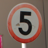

In [34]:
images[0]

оставим только заданные типы знаков

In [35]:
remain=[3,4,5,7,11,16,17,26,30,35,43,55]
a=[index for index,value in enumerate(labels) if value in remain]
inds=np.array(a, dtype=int)

images = images[inds]
labels = labels[inds]

In [36]:
index_dict = {value: index for index, value in enumerate(remain)}
labels=[index_dict[v] for v in labels]

num_classes = len(remain)
labels = to_categorical(labels, num_classes=num_classes)
# labels = tf.one_hot(labels.astype(np.int32), depth=num_classes)

In [37]:
images = images / 255

In [38]:
labels[-10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [45]:
data_augmentation = tf.keras.Sequential([
  layers.RandomTranslation(0.05, 0.05),
  # layers.RandomZoom((-0.2, -0.1)),
  layers.RandomRotation(0.05),
  # layers.RandomContrast(0.05),
  # layers.RandomBrightness(0.1)
])

увеличение RandomBrightness приводит к кратному уменьшению val_acc

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=(1,1),
                                      padding='same',
                                      activation='relu',
                                      input_shape=(small_shape[0], small_shape[1], 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3,3), strides=(1,1),
                                      padding='same',
                                      activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, (3,3), strides=(1,1),
                                  padding='same',
                                  activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

flatten дает 4-7к примерно. добавление dence ухудшает

In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# model.summary()

In [43]:
training_history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - acc: 0.1895 - loss: 2.2233 - val_acc: 0.5701 - val_loss: 1.1983
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - acc: 0.5930 - loss: 1.0453 - val_acc: 0.8118 - val_loss: 0.5223
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - acc: 0.8357 - loss: 0.4358 - val_acc: 0.9077 - val_loss: 0.2282
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - acc: 0.9237 - loss: 0.2198 - val_acc: 0.9391 - val_loss: 0.1628
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - acc: 0.9391 - loss: 0.1513 - val_acc: 0.9631 - val_loss: 0.1071
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - acc: 0.9703 - loss: 0.0876 - val_acc: 0.9797 - val_loss: 0.0608
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - acc: 0.9824 - loss: 0.0683 - val_acc: 0.9908 - val_loss: 0.0371
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - acc: 0.9889 - loss: 0.0385 - val_acc: 0.9908 - val_loss: 0.0291
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/

KeyboardInterrupt: 

In [46]:
modela = tf.keras.models.Sequential([
  data_augmentation,
  model
])
modela.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
training_history = modela.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=15
)

Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - acc: 0.9636 - loss: 0.0000e+00 - val_acc: 0.9889 - val_loss: 0.0000e+00
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - acc: 0.9811 - loss: 0.0000e+00 - val_acc: 0.9945 - val_loss: 0.0000e+00
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - acc: 0.9864 - loss: 0.0000e+00 - val_acc: 0.9889 - val_loss: 0.0000e+00
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - acc: 0.9881 - loss: 0.0000e+00 - val_acc: 0.9852 - val_loss: 0.0000e+00
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - acc: 0.9832 - loss: 0.0000e+00 - val_acc: 0.9889 - val_loss: 0.0000e+00
Epoch 6/15


KeyboardInterrupt: 

In [30]:
len(labels)

2710

In [32]:
len(y_train)

2168

In [47]:
len(y_test)

542

Была создана модель с 3 сверточными слоями и 1(2) полносвязными слоями. Тестирование проводилось на выборке размером 542. Модель доходит до 98-99% точности. Модель, в которую добавили аугментацию данных, обучается до сильно большей точности на первых эпохах.

Ссылка на эту colab https://colab.research.google.com/drive/1pVb0ksvD1eFD0A2sP-fcn-oYBJJ1OXTP?usp=sharing
